In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import gc
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier as gbm
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb


from sklearn.preprocessing import LabelEncoder

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0.5, 'Target'), Text(0.5, 0, 'rooms')]

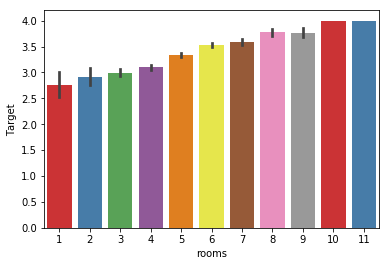

In [5]:
import seaborn as sns
barplot = sns.barplot(x='rooms',y='Target',data=train,palette="Set1") 
barplot.set(xlabel='rooms', ylabel='Target') # to set x and y labels 

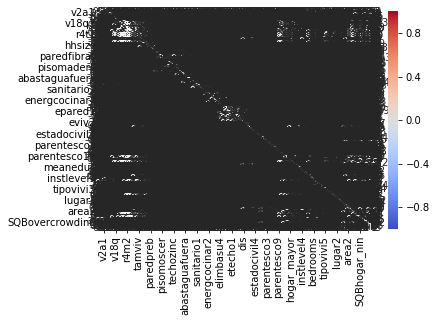

In [6]:
sns.heatmap(train.corr(),cmap="coolwarm",annot=True)

Text(0.5, 1.0, 'Years of schooling per household poverty level.')

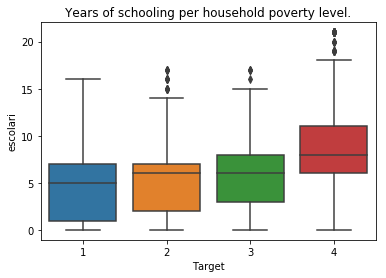

In [8]:
sns.boxplot(x='Target', y='escolari', data = train);
plt.title('Years of schooling per household poverty level.')

Text(0.5, 1.0, 'Presence of "Television" in house hold')

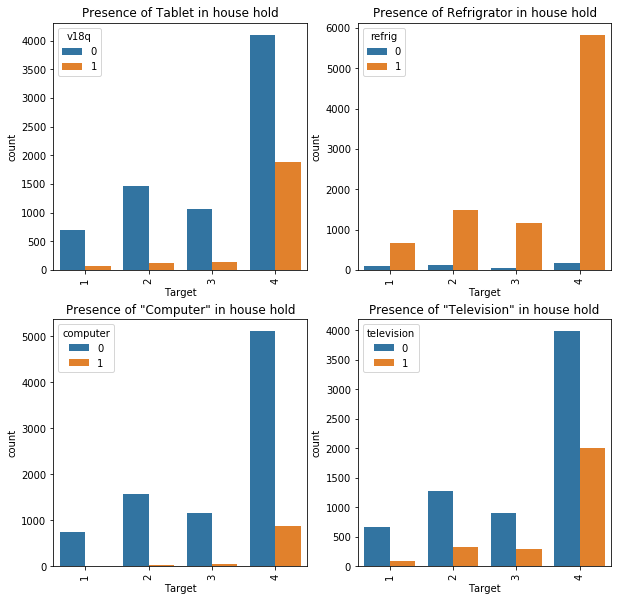

In [9]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.countplot("Target",hue='v18q', data=train)
plt.xticks(size=10,rotation=90)
plt.title('Presence of Tablet in house hold')

plt.subplot(2,2,2)
sns.countplot("Target",hue="refrig", data=train)
plt.xticks(size=10,rotation=90)
plt.title('Presence of Refrigrator in house hold')

plt.subplot(2,2,3)
sns.countplot("Target",hue="computer", data=train)
plt.xticks(size=10,rotation=90)
plt.title('Presence of "Computer" in house hold')

plt.subplot(2,2,4)
sns.countplot("Target",hue="television", data=train)
plt.xticks(size=10,rotation=90)
plt.title('Presence of "Television" in house hold')

In [10]:
train.dtypes

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
                    ...   
bedrooms             int64
overcrowding       float64
tipovivi1            int64
tipovivi2            int64
tipovivi3            int64
tipovivi4            int64
t

In [11]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [12]:
yes_no_map = {'no':0,'yes':1}
train['dependency'] = train['dependency'].replace(yes_no_map).astype(np.float32)
train['edjefe'] = train['edjefe'].replace(yes_no_map).astype(np.float32)
train['edjefa'] = train['edjefa'].replace(yes_no_map).astype(np.float32)

In [13]:
train[["dependency","edjefe","edjefa"]].describe()

,dependency,edjefe,edjefa
count,9557.000000,9557.000000,9557.00000
mean,1.149551,5.096788,2.89683
std,1.605967,5.246572,4.61198
min,0.000000,0.000000,0.00000
25%,0.333333,0.000000,0.00000
50%,0.666667,6.000000,0.00000
75%,1.333333,9.000000,6.00000
max,8.000000,21.000000,21.00000


In [14]:
 # Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,7928,0.829549
v18q1,7342,0.768233
v2a1,6860,0.717798
SQBmeaned,5,0.000523
meaneduc,5,0.000523
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [15]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for f in train.columns:
    if train[f].dtype=='object':
        print(f)
        lbl=preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values)+list(test[f].values))
        train[f]=lbl.transform(list(train[f].values))
        test[f]=lbl.transform(list(test[f].values))

Id
idhogar


In [16]:
y = train.iloc[:,137]
y.unique()

array([ 0,  4,  1,  9, 25, 16, 81, 36, 64, 49])

In [17]:
X = train.iloc[:,1:138]
X.shape

(9557, 137)

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler as ss
from sklearn.decomposition import PCA
my_imputer = SimpleImputer()
X = my_imputer.fit_transform(X)
scale = ss()
X = scale.fit_transform(X)
pca = PCA(0.95)
X = pca.fit_transform(X)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size = 0.2)

In [20]:
import time
from sklearn.ensemble import RandomForestClassifier

start = time.time()

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(X_test,y_test)

end = time.time()
print("RandomForestClassifier took {:.2f}s".format(end - start))

RandomForestClassifier took 4.34s


In [21]:
rf.score(X_test, y_test)

1.0

In [23]:
predictions = rf.predict(X_test)

In [24]:
predictions

array([ 1,  1,  1, ...,  4, 16,  1])

In [25]:
from sklearn.metrics import confusion_matrix
f  = confusion_matrix(y_test,predictions)
f

array([[594,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 488,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 452,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 247,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  77,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  12,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2]])

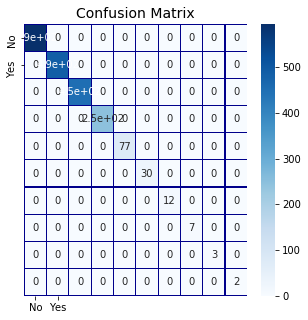

In [26]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(f, 
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [27]:
modelneigh = KNeighborsClassifier(n_neighbors=4)

In [28]:
start = time.time()
modelneigh = modelneigh.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.0004896839459737142

In [29]:
predictions = modelneigh.predict(X_test)

In [30]:
predictions

array([ 1,  1,  1, ...,  4, 16,  4])

In [31]:
(predictions == y_test).sum()/y_test.size

0.747907949790795

In [32]:
from sklearn.metrics import confusion_matrix
f  = confusion_matrix(y_test,predictions)
f

array([[548,  37,   8,   1,   0,   0,   0,   0,   0,   0],
       [140, 294,  47,   7,   0,   0,   0,   0,   0,   0],
       [ 44,  93, 300,  14,   1,   0,   0,   0,   0,   0],
       [  5,  15,  55, 171,   1,   0,   0,   0,   0,   0],
       [  0,   2,   4,   6,  65,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0,  10,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2]])

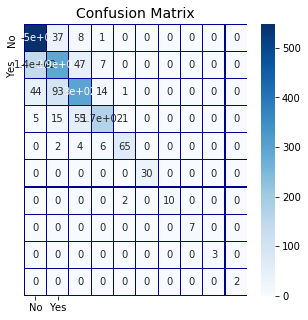

In [33]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(f, 
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
modelgbm=gbm()

In [37]:
import time
start = time.time()
modelgbm = modelgbm.fit(X_train, y_train)
end = time.time()
(end-start)/60

1.02148357629776

In [38]:
predictions = modelgbm.predict(X_test)

predictions

array([ 1,  1,  4, ...,  4, 16,  1])

In [39]:
(predictions == y_test).sum()/y_test.size

0.8049163179916318

In [40]:
from sklearn.metrics import confusion_matrix
f  = confusion_matrix(y_test,predictions)
f

array([[537,  55,   2,   0,   0,   0,   0,   0,   0,   0],
       [ 61, 368,  56,   3,   0,   0,   0,   0,   0,   0],
       [  2,  70, 347,  28,   4,   1,   0,   0,   0,   0],
       [  0,   0,  52, 187,   8,   0,   0,   0,   0,   0],
       [  0,   0,   3,  15,  59,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   4,  24,   1,   0,   0,   0],
       [  0,   0,   0,   1,   3,   0,   8,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   1,   5,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2]])

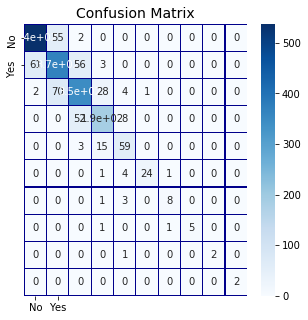

In [41]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(f, 
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
modelxgb=XGBClassifier()

In [45]:
import time
start = time.time()
modelxgb = modelxgb.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.6949735681215922

In [46]:
prdictions = modelxgb.predict(X_test)

predictions

array([ 1,  1,  4, ...,  4, 16,  1])

In [47]:
(predictions == y_test).sum()/y_test.size

0.8049163179916318

In [48]:
from sklearn.metrics import confusion_matrix
f  = confusion_matrix(y_test,predictions)
f

array([[537,  55,   2,   0,   0,   0,   0,   0,   0,   0],
       [ 61, 368,  56,   3,   0,   0,   0,   0,   0,   0],
       [  2,  70, 347,  28,   4,   1,   0,   0,   0,   0],
       [  0,   0,  52, 187,   8,   0,   0,   0,   0,   0],
       [  0,   0,   3,  15,  59,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   4,  24,   1,   0,   0,   0],
       [  0,   0,   0,   1,   3,   0,   8,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   1,   5,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2]])

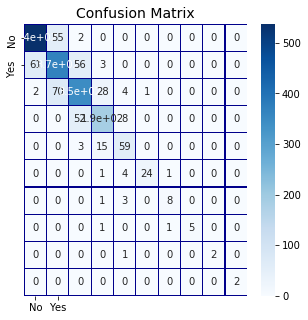

In [49]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(f, 
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [51]:
modellgb = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)

In [52]:
import time
start = time.time()
modellgb = modellgb.fit(X_train, y_train)
end = time.time()
(end-start)/60

1.5267801642417909

In [53]:
predictions = modellgb.predict(X_test)

predictions

array([ 1,  1,  1, ...,  4, 16,  1])

In [54]:
(predictions == y_test).sum()/y_test.size

0.9314853556485355

In [55]:
from sklearn.metrics import confusion_matrix
f  = confusion_matrix(y_test,predictions)
f

array([[576,  18,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 29, 440,  19,   0,   0,   0,   0,   0,   0,   0],
       [  0,  25, 413,  12,   2,   0,   0,   0,   0,   0],
       [  0,   0,  14, 230,   3,   0,   0,   0,   0,   0],
       [  0,   0,   2,   3,  72,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   1,   3,   0,   8,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2]])

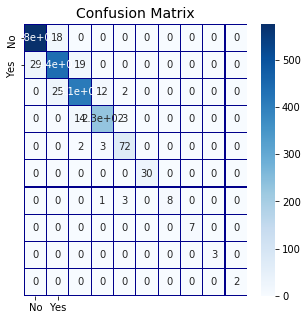

In [56]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(f, 
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [66]:
from sklearn.ensemble import ExtraTreesClassifier
extc = ExtraTreesClassifier(n_estimators=580,max_features= 128,criterion= 'entropy',min_samples_split= 3,
                            max_depth= 30, min_samples_leaf= 8)      
start = time.time()
extc = extc.fit(X_train,y_train)
end = time.time()
(end-start)/60

ValueError: max_features must be in (0, n_features]

In [67]:
predictions = extc.predict(X_test)

predictions

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [70]:
(predictions == y_test).sum()/y_test.size

0.9314853556485355

In [71]:
from sklearn.metrics import confusion_matrix
f  = confusion_matrix(y_test,predictions)
f

array([[576,  18,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 29, 440,  19,   0,   0,   0,   0,   0,   0,   0],
       [  0,  25, 413,  12,   2,   0,   0,   0,   0,   0],
       [  0,   0,  14, 230,   3,   0,   0,   0,   0,   0],
       [  0,   0,   2,   3,  72,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   1,   3,   0,   8,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2]])

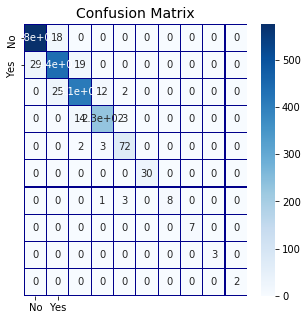

In [72]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(f, 
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
from sklearn.ensemble  import  RandomForestClassifier as rf
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV as BayesSCV
bayes_tuner = BayesSCV(RandomForestClassifier(n_jobs = 2),

    #  Estimator parameters to be change/tune
    {
        'n_estimators': (100, 500),           
        'criterion': ['gini', 'entropy'],    
        'max_depth': (4, 100),               
        'max_features' : (10,64),             
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   
    },

    # 2.13
    n_iter=32,            
    cv = 3               
)

In [ ]:
bayes_tuner.fit(X_train, y_train)

In [ ]:
opt.best_params_

In [ ]:
opt.best_score_

In [ ]:
opt.score(X_test, y_test)

In [ ]:
opt.cv_results_['params']